python 3.11.9 
tensorflow 2.20 
keras 3.5 


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model
import cv2
from skimage import io

In [3]:
BASE_DIR = r"D:\New folder (3)"
MODEL_PATH = os.path.join(BASE_DIR, r"D:\New folder (3)\best_model1_1_checkpoint.keras")
TRAIN_CSV = os.path.join(BASE_DIR, "Train.csv")
IMG_SIZE = (64, 64)

# NHÃN TIẾNG VIỆT

labels_vi = {
    0: "Giới hạn tốc độ (20 km/h)",
    1: "Giới hạn tốc độ (30 km/h)",
    2: "Giới hạn tốc độ (50 km/h)",
    3: "Giới hạn tốc độ (60 km/h)",
    4: "Giới hạn tốc độ (70 km/h)",
    5: "Giới hạn tốc độ (80 km/h)",
    6: "Hết giới hạn tốc độ (80 km/h)",
    7: "Giới hạn tốc độ (100 km/h)",
    8: "Giới hạn tốc độ (120 km/h)",
    9: "Cấm vượt",
    10: "Cấm xe tải > 3.5 tấn vượt",
    11: "Đường ưu tiên",
    12: "Đường chính (ưu tiên)",
    13: "Nhường đường",
    14: "Dừng lại",
    15: "Cấm mọi phương tiện",
    16: "Cấm xe tải > 3.5 tấn",
    17: "Cấm vào",
    18: "Cảnh báo nguy hiểm",
    19: "Khúc cua trái",
    20: "Khúc cua phải",
    21: "Hai khúc cua liên tiếp",
    22: "Đường gập ghềnh",
    23: "Đường trơn trượt",
    24: "Đường hẹp bên phải",
    25: "Công trường phía trước",
    26: "Có đèn giao thông phía trước",
    27: "Lối đi bộ phía trước",
    28: "Trẻ em qua đường",
    29: "Đường xe đạp cắt ngang",
    30: "Nguy hiểm băng tuyết/đóng băng",
    31: "Thú rừng qua đường",
    32: "Hết mọi giới hạn cấm",
    33: "Bắt buộc rẽ phải",
    34: "Bắt buộc rẽ trái",
    35: "Bắt buộc đi thẳng",
    36: "Đi thẳng hoặc rẽ phải",
    37: "Đi thẳng hoặc rẽ trái",
    38: "Giữ bên phải",
    39: "Giữ bên trái",
    40: "Vòng xuyến bắt buộc",
    41: "Hết cấm vượt (xe con)",
    42: "Hết cấm vượt (xe tải)"
}

# LOAD CSV LẤY MAPPING ĐÚNG NHƯ KHI TRAIN

train_df = pd.read_csv(TRAIN_CSV)
train_df["Path"] = train_df["Path"].str.replace("Train/", "", regex=False)
train_df["ClassId_str"] = train_df["ClassId"].astype(str)

unique_labels = sorted(train_df["ClassId_str"].unique())
num_classes = len(unique_labels)

reverse_map = {i: int(unique_labels[i]) for i in range(num_classes)}

In [4]:
# Load model & YOLO
model = tf.keras.models.load_model(MODEL_PATH)
print("Model load thành công!")

Model load thành công!


In [5]:
# Lọc tất cả các đối tượng có màu đỏ hoặc xanh lam
def detect_sign_regions(image_bgr):
    hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

    # Vùng đỏ (biển cấm)
    lower_red1 = np.array([0, 80, 80])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 80, 80])
    upper_red2 = np.array([180, 255, 255])
    mask_red = cv2.bitwise_or(cv2.inRange(hsv, lower_red1, upper_red1),
                              cv2.inRange(hsv, lower_red2, upper_red2))

    # Vùng xanh biển bắt buộc
    lower_blue = np.array([90, 80, 80])
    upper_blue = np.array([130, 255, 255])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    # Gộp mask
    mask = cv2.bitwise_or(mask_red, mask_blue)

    # Làm sạch mask
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return mask

In [6]:
# Bounding boxes theo màu sắc 
def extract_nearly_square_boxes(mask, min_area=500, min_extent=0.4, max_ratio=1.3):
    """
    Dùng để lọc và trích xuất các bounding box từ ảnh mask nhị phân (0–255)
    Chỉ giữ lại những vùng có hình dạng gần vuông và đủ đặc
    """
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []

    for c in cnts:
        area = cv2.contourArea(c)
        if area < min_area:
            continue

        x, y, w, h = cv2.boundingRect(c)

        # Kiểm tra gần vuông: ratio = chiều dài / chiều rộng
        ratio = max(w, h) / float(min(w, h))
        if ratio > max_ratio:
            continue

        # Diện tích so với bounding box
        extent = area / float(w * h)
        if extent < min_extent:
            continue

        boxes.append((x, y, w, h))

    return boxes

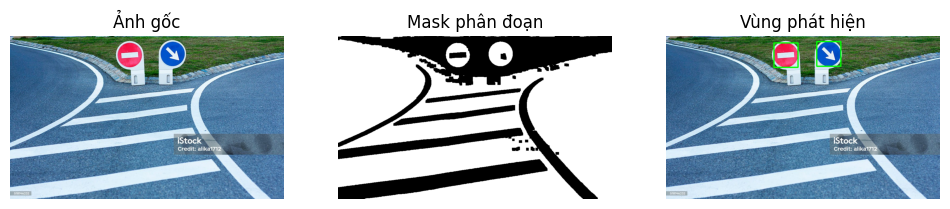

In [7]:
image_path = r"D:\New folder (3)\traffic_detection\1.jpg"
#image_path = r"D:\New folder (3)\traffic_detection\2.jpg"
#image_path = r"D:\New folder (3)\traffic_detection\3.jpg"
#image_path = r"D:\New folder (3)\traffic_detection\4.jpg"
#image_path = r"D:\New folder (3)\traffic_detection\5.jpg"
#image_path = r"D:\New folder (3)\traffic_detection\6.jpg"
#image_path = r"D:\New folder (3)\traffic_detection\7.jpg"
image_bgr = cv2.imread(image_path)

if image_bgr is None:
    raise ValueError(" Không tìm thấy ảnh — kiểm tra lại đường dẫn!")

mask = detect_sign_regions(image_bgr)
boxes = extract_nearly_square_boxes(mask)

# HIỂN THỊ KẾT QUẢ

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Ảnh gốc")
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Mask phân đoạn")
plt.imshow(mask, cmap="gray")
plt.axis("off")

# Vẽ box lên ảnh
image_boxed = image_bgr.copy()
for (x, y, w, h) in boxes:
    cv2.rectangle(image_boxed, (x, y), (x+w, y+h), (0, 255, 0), 3)

plt.subplot(1, 3, 3)
plt.title("Vùng phát hiện")
plt.imshow(cv2.cvtColor(image_boxed, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()

In [8]:
def classify_roi(model, roi_bgr):
    roi_rgb = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2RGB)
    roi_img = Image.fromarray(roi_rgb).resize(IMG_SIZE)

    arr = np.array(roi_img) / 255.0
    arr = np.expand_dims(arr, axis=0)

    # Predict
    pred = model.predict(arr, verbose=0)

    # Nhãn theo thứ tự 0..42 của model
    predicted_class = np.argmax(pred)

    # Chuyển sang ClassId gốc (mapping khi train)
    true_class_id = reverse_map[predicted_class]

    # Lấy nhãn tiếng Việt đúng lớp thật
    label_vi = labels_vi.get(true_class_id, f"ID {true_class_id}")

    confidence = float(np.max(pred)) * 100

    return label_vi, confidence


In [9]:
from PIL import ImageFont, ImageDraw, Image

FONT_PATH = r"D:\New folder (3)\Roboto\Roboto-VariableFont_wdth,wght.ttf"

def draw_text_vn(image_bgr, text, x, y, font_size=18):
    # Chuyển sang PIL (RGB)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(image_rgb)

    # Chuẩn bị vẽ tiếng Việt
    draw = ImageDraw.Draw(pil_img)
    font = ImageFont.truetype(FONT_PATH, font_size)

    # Vẽ text
    draw.text((x, y), text, font=font, fill=(255,0,0))

    # Convert ngược về BGR
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)


In [10]:
def detect_and_predict(model, img_path):
    image_bgr = cv2.imread(img_path)
    mask = detect_sign_regions(image_bgr)
    boxes = extract_nearly_square_boxes(mask)

    result = image_bgr.copy()

    for (x, y, w, h) in boxes:
        roi = image_bgr[y:y+h, x:x+w]

        # Classify 
        label_vi, conf = classify_roi(model, roi)
        text = f"{label_vi} ({conf:.1f}%)"

        # Vẽ khung bằng OpenCV
        cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Vẽ CHỮ tiếng Việt bằng PIL
        result = draw_text_vn(result, text, x, y-25, font_size=20)

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    return result


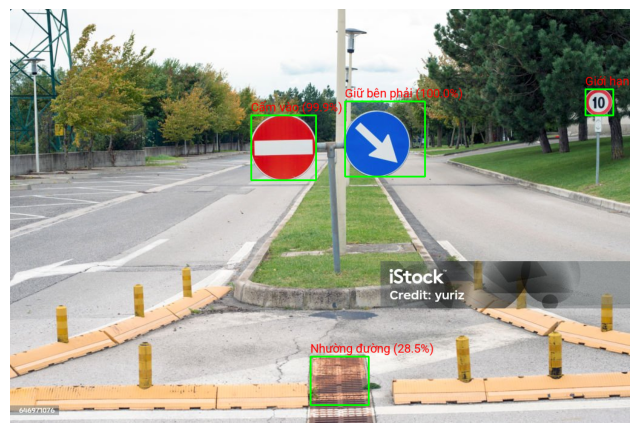

array([[[105,  95,  77],
        [ 89,  81,  64],
        [147, 138, 124],
        ...,
        [ 54,  68,  40],
        [ 55,  67,  39],
        [ 57,  69,  41]],

       [[ 97,  87,  70],
        [156, 148, 131],
        [225, 217, 204],
        ...,
        [ 56,  70,  42],
        [ 60,  72,  44],
        [ 63,  75,  47]],

       [[155, 146, 132],
        [230, 223, 208],
        [255, 255, 245],
        ...,
        [ 51,  65,  37],
        [ 52,  66,  38],
        [ 51,  65,  37]],

       ...,

       [[210, 207, 209],
        [205, 202, 204],
        [205, 202, 204],
        ...,
        [211, 206, 208],
        [208, 203, 205],
        [205, 200, 202]],

       [[206, 203, 205],
        [201, 198, 200],
        [200, 197, 199],
        ...,
        [211, 206, 208],
        [209, 204, 206],
        [206, 201, 203]],

       [[204, 201, 203],
        [198, 195, 197],
        [197, 194, 196],
        ...,
        [211, 206, 208],
        [210, 205, 207],
        [208, 203, 205]]

In [31]:
detect_and_predict(model, r"D:\New folder (3)\traffic_detection\2.jpg")

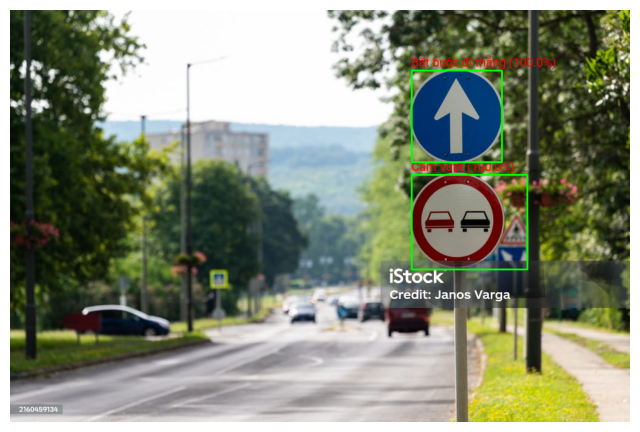

array([[[ 15,  45,  26],
        [ 18,  48,  29],
        [ 21,  53,  34],
        ...,
        [  9, 141, 124],
        [ 20, 118, 104],
        [ 11,  93,  80]],

       [[ 14,  44,  25],
        [ 17,  47,  28],
        [ 20,  52,  33],
        ...,
        [  6, 140, 122],
        [  2, 106,  89],
        [  0,  74,  58]],

       [[ 14,  44,  25],
        [ 16,  46,  27],
        [ 18,  50,  31],
        ...,
        [  6, 145, 124],
        [  0, 105,  85],
        [  0,  71,  51]],

       ...,

       [[229, 230, 234],
        [229, 230, 234],
        [228, 229, 233],
        ...,
        [213, 229, 245],
        [209, 225, 241],
        [205, 221, 237]],

       [[228, 229, 233],
        [227, 228, 232],
        [226, 227, 231],
        ...,
        [212, 228, 244],
        [211, 227, 243],
        [210, 226, 242]],

       [[226, 227, 231],
        [226, 227, 231],
        [225, 226, 230],
        ...,
        [216, 231, 247],
        [215, 231, 247],
        [214, 230, 246]]

In [33]:
detect_and_predict(model, r"D:\New folder (3)\traffic_detection\3.jpg")


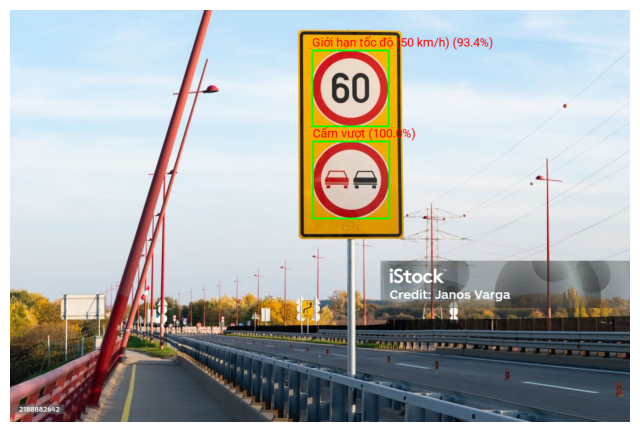

array([[[252, 227, 195],
        [252, 227, 195],
        [252, 227, 195],
        ...,
        [244, 225, 192],
        [244, 225, 192],
        [244, 225, 192]],

       [[252, 227, 195],
        [252, 227, 195],
        [252, 227, 195],
        ...,
        [245, 226, 193],
        [245, 226, 193],
        [245, 226, 193]],

       [[252, 227, 193],
        [252, 227, 193],
        [252, 227, 193],
        ...,
        [246, 226, 195],
        [246, 226, 195],
        [246, 226, 195]],

       ...,

       [[117, 137, 208],
        [121, 138, 217],
        [118, 131, 229],
        ...,
        [ 84,  71,  57],
        [ 82,  69,  55],
        [ 80,  67,  53]],

       [[119, 139, 204],
        [121, 140, 213],
        [116, 131, 223],
        ...,
        [ 83,  70,  56],
        [ 80,  67,  53],
        [ 78,  65,  51]],

       [[121, 141, 199],
        [120, 139, 207],
        [118, 135, 222],
        ...,
        [ 82,  69,  55],
        [ 80,  67,  53],
        [ 83,  70,  56]]

In [35]:
detect_and_predict(model, r"D:\New folder (3)\traffic_detection\5.jpg")

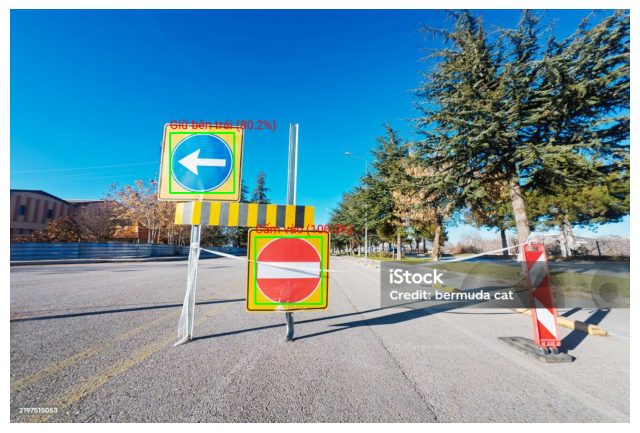

array([[[210, 126,   0],
        [210, 126,   0],
        [210, 126,   0],
        ...,
        [175, 113,  29],
        [195, 138,  23],
        [207, 151,  20]],

       [[210, 126,   0],
        [210, 126,   0],
        [210, 126,   0],
        ...,
        [186, 124,  34],
        [196, 136,  22],
        [198, 140,  11]],

       [[210, 126,   0],
        [210, 126,   0],
        [210, 126,   0],
        ...,
        [196, 134,  32],
        [199, 136,  22],
        [196, 133,  11]],

       ...,

       [[148, 147, 157],
        [146, 145, 154],
        [119, 121, 129],
        ...,
        [200, 203, 201],
        [196, 199, 197],
        [191, 194, 192]],

       [[143, 145, 155],
        [131, 133, 143],
        [127, 129, 139],
        ...,
        [199, 202, 200],
        [193, 196, 194],
        [189, 192, 190]],

       [[139, 148, 158],
        [119, 126, 135],
        [140, 147, 156],
        ...,
        [197, 200, 198],
        [192, 195, 193],
        [188, 191, 189]]

In [36]:
detect_and_predict(model, r"D:\New folder (3)\traffic_detection\6.jpg")

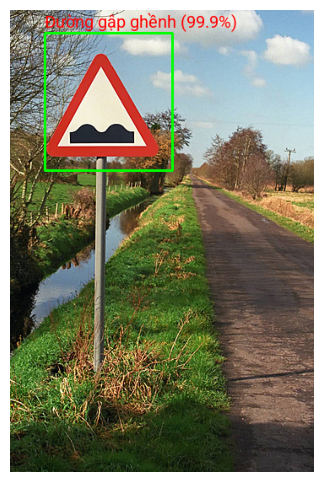

array([[[151, 117, 117],
        [140, 122, 121],
        [116, 115, 111],
        ...,
        [205, 191, 173],
        [203, 189, 171],
        [202, 188, 170]],

       [[105, 119, 108],
        [ 91,  99,  88],
        [ 84,  87,  72],
        ...,
        [205, 188, 167],
        [206, 189, 168],
        [204, 187, 166]],

       [[ 58,  73,  76],
        [ 96, 101, 104],
        [ 83,  82,  84],
        ...,
        [207, 188, 161],
        [211, 192, 165],
        [209, 190, 163]],

       ...,

       [[ 33,  50,  39],
        [ 35,  51,  40],
        [ 17,  39,  27],
        ...,
        [ 24,  23,  25],
        [ 31,  30,  32],
        [ 33,  32,  34]],

       [[ 38,  55,  44],
        [  0,  10,   0],
        [  4,  28,  16],
        ...,
        [ 36,  35,  37],
        [ 39,  38,  40],
        [ 38,  37,  39]],

       [[ 25,  42,  31],
        [ 11,  27,  16],
        [ 24,  48,  36],
        ...,
        [ 40,  39,  41],
        [ 45,  44,  46],
        [ 44,  43,  45]]

In [37]:
detect_and_predict(model, r"D:\New folder (3)\traffic_detection\7.jpg")

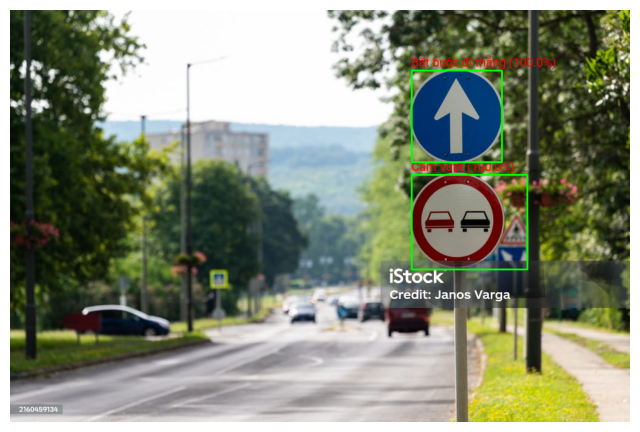

array([[[ 15,  45,  26],
        [ 18,  48,  29],
        [ 21,  53,  34],
        ...,
        [  9, 141, 124],
        [ 20, 118, 104],
        [ 11,  93,  80]],

       [[ 14,  44,  25],
        [ 17,  47,  28],
        [ 20,  52,  33],
        ...,
        [  6, 140, 122],
        [  2, 106,  89],
        [  0,  74,  58]],

       [[ 14,  44,  25],
        [ 16,  46,  27],
        [ 18,  50,  31],
        ...,
        [  6, 145, 124],
        [  0, 105,  85],
        [  0,  71,  51]],

       ...,

       [[229, 230, 234],
        [229, 230, 234],
        [228, 229, 233],
        ...,
        [213, 229, 245],
        [209, 225, 241],
        [205, 221, 237]],

       [[228, 229, 233],
        [227, 228, 232],
        [226, 227, 231],
        ...,
        [212, 228, 244],
        [211, 227, 243],
        [210, 226, 242]],

       [[226, 227, 231],
        [226, 227, 231],
        [225, 226, 230],
        ...,
        [216, 231, 247],
        [215, 231, 247],
        [214, 230, 246]]

In [19]:
detect_and_predict(model, r"D:\New folder (3)\istockphoto-2160459134-1024x1024.jpg")

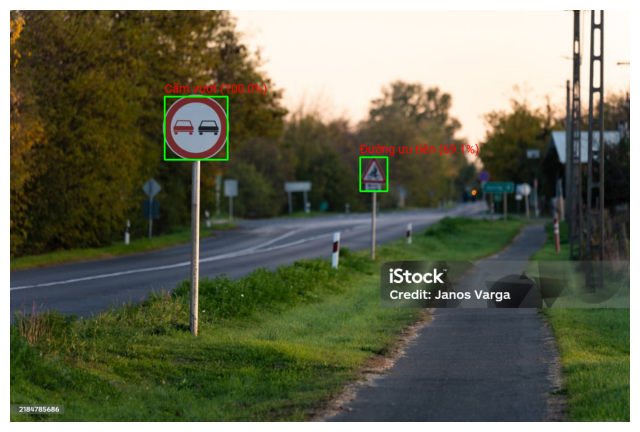

array([[[150, 183, 216],
        [158, 192, 222],
        [143, 173, 202],
        ...,
        [249, 252, 255],
        [249, 252, 255],
        [249, 252, 255]],

       [[157, 191, 221],
        [148, 180, 209],
        [130, 160, 187],
        ...,
        [249, 252, 255],
        [249, 252, 255],
        [249, 252, 255]],

       [[145, 178, 204],
        [114, 147, 173],
        [100, 131, 156],
        ...,
        [249, 252, 255],
        [249, 252, 255],
        [249, 252, 255]],

       ...,

       [[ 35, 102,  81],
        [ 28,  97,  76],
        [ 19,  91,  69],
        ...,
        [ 11,  63,  33],
        [ 16,  68,  38],
        [ 18,  72,  42]],

       [[ 33, 102,  81],
        [ 25,  97,  75],
        [ 17,  90,  68],
        ...,
        [  8,  62,  32],
        [ 15,  69,  39],
        [ 22,  76,  46]],

       [[ 25,  97,  75],
        [ 23,  95,  73],
        [ 18,  91,  69],
        ...,
        [ 12,  66,  37],
        [ 20,  74,  44],
        [ 24,  81,  50]]

In [61]:
detect_and_predict(model, r"D:\New folder (3)\istockphoto-2184785686-1024x1024.jpg")